In [3]:
# Load stored variables
%store -r final_sales_df

## Store Performance Clustering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate Revenue: Quantity * Unit Price USD
final_sales_df['Revenue'] = final_sales_df['Quantity'] * final_sales_df['Unit Price USD'].astype(float)

# Calculate Revenue: Quantity * Unit Price USD
final_sales_df['Cost'] = final_sales_df['Quantity'] * final_sales_df['Unit Cost USD'].astype(float)

# Calculate Revenue: Quantity * Unit Price USD
final_sales_df['Profit'] = final_sales_df['Revenue'] - final_sales_df['Cost']

# Aggregate performance metrics by StoreKey
store_performance = final_sales_df.groupby('StoreKey').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Cost=('Cost', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Quantity=('Quantity', 'sum')
).reset_index()

# Removing online store
store_performance = store_performance[store_performance['StoreKey'] != 0]

In [67]:
# Standardize the data for clustering
scaler = StandardScaler()
store_features = scaler.fit_transform(store_performance[['Total_Revenue', 'Total_Cost', 'Total_Profit', 'Total_Quantity']])

In [69]:
def optimise_k_means(data, max_k):
	means = []
	inertias = []
	
	for k in range(1, max_k):
		kmeans = KMeans(n_clusters=k)
		kmeans.fit_predict(data)

		means.append(k)
		inertias.append(kmeans.inertia_)

	#Generate the elbow plot
	fig = plt.subplots(figsize=(10,5))
	plt.plot(means, inertias, 'o-')
	plt.xlabel('Number of Clusters')
	plt.ylabel('Inertia')
	plt.grid(True)
	plt.show()

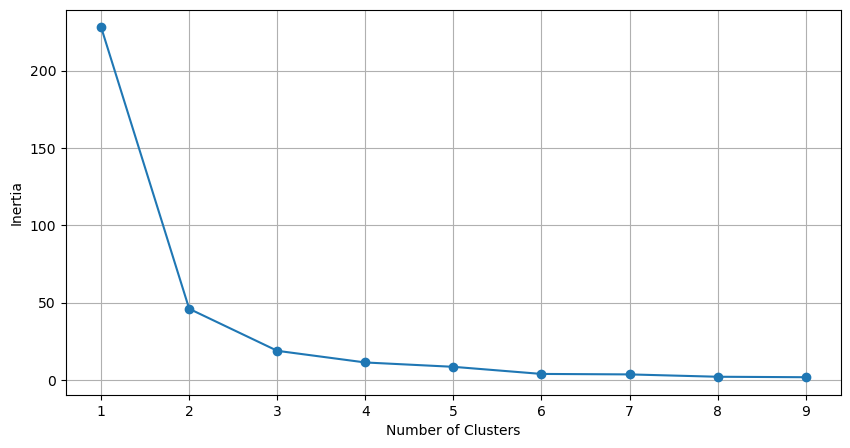

In [109]:
import warnings
warnings.filterwarnings('ignore')
optimise_k_means(store_features,10)

#### Let’s try using 3 clusters as the optimal number. A good model is one with low inertia AND a low number of clusters.

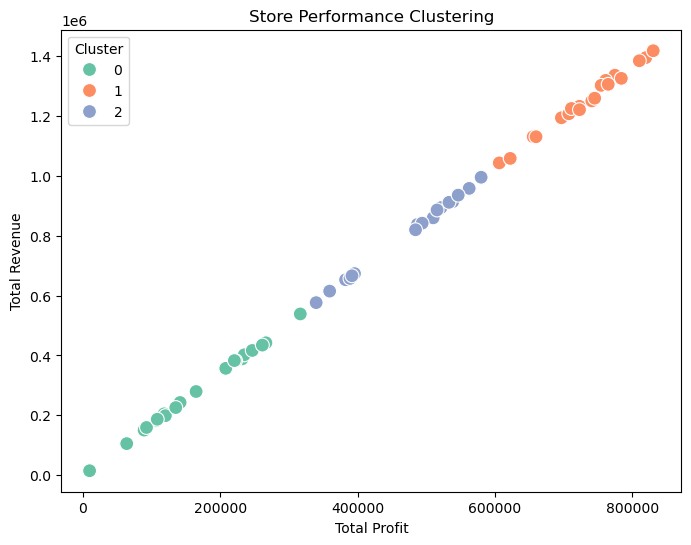

In [107]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
store_performance['Cluster'] = kmeans.fit_predict(store_features)

# Visualize clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=store_performance, 
    x='Total_Profit', 
    y='Total_Revenue', 
    hue='Cluster', 
    palette='Set2', 
    s=100
)
plt.title('Store Performance Clustering')
plt.xlabel('Total Profit')
plt.ylabel('Total Revenue')
plt.legend(title='Cluster')
plt.show()

In [91]:
# Group by the cluster label
cluster_summary = store_performance.groupby('Cluster').agg(
    Min_Revenue=('Total_Revenue', 'min'),
    Max_Revenue=('Total_Revenue', 'max'),
    Min_Profit=('Total_Profit', 'min'),
    Max_Profit=('Total_Profit', 'max'),
    Store_Count=('StoreKey', 'nunique')
).reset_index()

In [103]:
cluster_summary_display = cluster_summary

# Format Min and Max Revenue to show in thousands
cluster_summary_display['Min_Revenue'] = cluster_summary_display['Min_Revenue'].apply(lambda x: f'{x / 1000:.1f}K')
cluster_summary_display['Max_Revenue'] = cluster_summary_display['Max_Revenue'].apply(lambda x: f'{x / 1000:.1f}K')
cluster_summary_display['Min_Profit'] = cluster_summary_display['Min_Profit'].apply(lambda x: f'{x / 1000:.1f}K')
cluster_summary_display['Max_Profit'] = cluster_summary_display['Max_Profit'].apply(lambda x: f'{x / 1000:.1f}K')

print(cluster_summary_display)

   Cluster Min_Revenue Max_Revenue Min_Profit Max_Profit  Store_Count
0        0       15.2K      538.8K       9.5K     316.4K           20
1        1     1043.2K     1417.9K     606.3K     830.6K           20
2        2      576.6K      995.3K     339.6K     579.8K           17


#### We can classify the stores into three groups: one with profits ranging from 9.5K to 316.4K, a second group with profits between 339.6K and 579.8K, and a third group with profits ranging from 606.3K to 830.6K.